Load all packages you need.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pip install mlxtend

from itertools import combinations
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample


Read the dataset that you prepared yesterday afternoon (without outlier and missing data). 

In [2]:
df = pd.read_csv('../data/diabetes_cleaned.csv')
print(df.columns.tolist())

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


Let's apply association rule learning on the variables "Age" and "Pregnancies". Unfortunately, the dataset is not optimal for association rule learning, since most variables are continouus. <br>
As a work around, we start by binning the data.

In [6]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../data/diabetes_cleaned.csv')

# Bin the "Age" and "Pregnancies" data
age_bins = [0, 20, 30, 40, 50, 60, 70, 80]
pregnancies_bins = [0, 2, 4, 6, 8, 10, 12, 14, 16]

df['Age_bin'] = pd.cut(df['Age'], bins=age_bins, labels=[f'Age_{i}' for i in range(len(age_bins)-1)])
df['Pregnancies_bin'] = pd.cut(df['Pregnancies'], bins=pregnancies_bins, labels=[f'Pregnancies_{i}' for i in range(len(pregnancies_bins)-1)])

# Ensure the binned columns are correctly created
print(df[['Age_bin', 'Pregnancies_bin']].head())

# Transform the binned data into dummy variables
df_dummies = pd.get_dummies(df[['Age_bin', 'Pregnancies_bin']])

# Display the first few rows of the transformed dataframe
print(df_dummies.head())

  Age_bin Pregnancies_bin
0   Age_3   Pregnancies_2
1   Age_2   Pregnancies_0
2   Age_2   Pregnancies_3
3   Age_1   Pregnancies_0
4   Age_1   Pregnancies_2
   Age_bin_Age_0  Age_bin_Age_1  Age_bin_Age_2  Age_bin_Age_3  Age_bin_Age_4  \
0          False          False          False           True          False   
1          False          False           True          False          False   
2          False          False           True          False          False   
3          False           True          False          False          False   
4          False           True          False          False          False   

   Age_bin_Age_5  Age_bin_Age_6  Pregnancies_bin_Pregnancies_0  \
0          False          False                          False   
1          False          False                           True   
2          False          False                          False   
3          False          False                           True   
4          False          False  

Next, transform the categorical variables to dummy variables (e.g. age_bin < 30 = True).

  Age_bin Pregnancies_bin
0   41-50             5-6
1   31-40               0
2   31-40             7-8
3   21-30               0
4   21-30             3-4
   Age_bin_21-30  Age_bin_31-40  Age_bin_41-50  Age_bin_51-60  Age_bin_61-70  \
0          False          False           True          False          False   
1          False           True          False          False          False   
2          False           True          False          False          False   
3           True          False          False          False          False   
4           True          False          False          False          False   

   Age_bin_71-80  Pregnancies_bin_1-2  Pregnancies_bin_3-4  \
0          False                False                False   
1          False                False                False   
2          False                False                False   
3          False                False                False   
4          False                False                

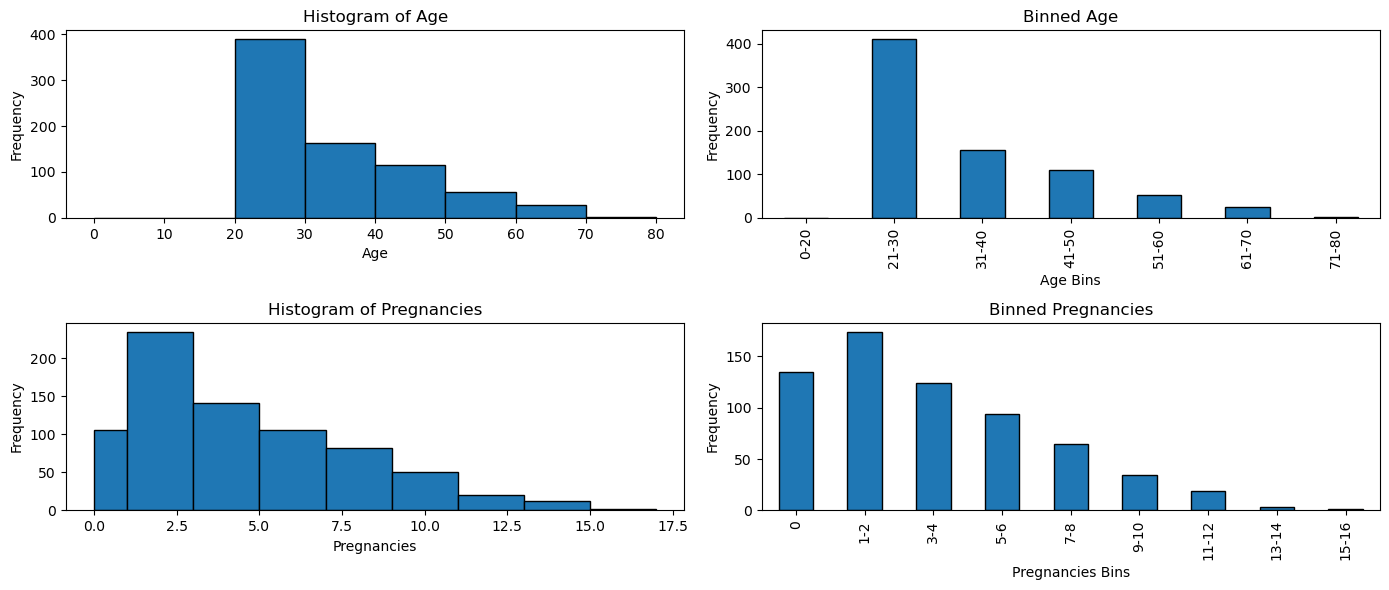

In [16]:


# Bin the "Age" and "Pregnancies" data with descriptive labels
age_bins = [0, 20, 30, 40, 50, 60, 70, 80]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']

pregnancies_bins = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17]
pregnancies_labels = ['0', '1-2', '3-4', '5-6', '7-8', '9-10', '11-12', '13-14', '15-16']

df['Age_bin'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
df['Pregnancies_bin'] = pd.cut(df['Pregnancies'], bins=pregnancies_bins, labels=pregnancies_labels)

# Ensure the binned columns are correctly created
print(df[['Age_bin', 'Pregnancies_bin']].head())

# Transform the binned data into dummy variables
df_dummies = pd.get_dummies(df[['Age_bin', 'Pregnancies_bin']], drop_first=True)

# Display the first few rows of the transformed dataframe
print(df_dummies.head())

# Visualize the original and binned data
plt.figure(figsize=(14, 6))

# Histogram for original Age data
plt.subplot(2, 2, 1)
plt.hist(df['Age'], bins=age_bins, edgecolor='k')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Bar plot for binned Age data
plt.subplot(2, 2, 2)
df['Age_bin'].value_counts().sort_index().plot(kind='bar', edgecolor='k')
plt.title('Binned Age')
plt.xlabel('Age Bins')
plt.ylabel('Frequency')

# Histogram for original Pregnancies data
plt.subplot(2, 2, 3)
plt.hist(df['Pregnancies'], bins=pregnancies_bins, edgecolor='k')
plt.title('Histogram of Pregnancies')
plt.xlabel('Pregnancies')
plt.ylabel('Frequency')

# Bar plot for binned Pregnancies data
plt.subplot(2, 2, 4)
df['Pregnancies_bin'].value_counts().sort_index().plot(kind='bar', edgecolor='k')
plt.title('Binned Pregnancies')
plt.xlabel('Pregnancies Bins')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Find frequent group bins and identify the corresponding association rules. Use different threshold rules for rule identification. <br>

In [17]:
from mlxtend.frequent_patterns import apriori, association_rules

# Convert the binned data to one-hot encoded format
df_dummies = pd.get_dummies(df_dummies)

# Step 1: Determine selection rules
min_support = 0.1
max_length = 2
min_confidence = 0.5
max_rules = 10

# Step 2: Detect antecedents using the Apriori algorithm
frequent_itemsets = apriori(df_dummies, min_support=min_support, use_colnames=True, max_len=max_length)

# Step 3: Calculate rule metrics using the association_rules function
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

# Step 4: Identify relevant rules
# Sort rules by lift and select the top 'max_rules' rules
rules = rules.sort_values(by='lift', ascending=False).head(max_rules)

# Display the frequent itemsets and the association rules
print("Frequent Itemsets:")
print(frequent_itemsets)

print("\nAssociation Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Frequent Itemsets:
    support                              itemsets
0  0.543046                       (Age_bin_21-30)
1  0.205298                       (Age_bin_31-40)
2  0.145695                       (Age_bin_41-50)
3  0.230464                 (Pregnancies_bin_1-2)
4  0.164238                 (Pregnancies_bin_3-4)
5  0.124503                 (Pregnancies_bin_5-6)
6  0.186755  (Pregnancies_bin_1-2, Age_bin_21-30)

Association Rules:
             antecedents      consequents   support  confidence     lift
0  (Pregnancies_bin_1-2)  (Age_bin_21-30)  0.186755    0.810345  1.49222


Support: How often the rules 
Confidence: How high rate of the rules considered as true

Lift: >1 good indication that the rules is not coincidental